# Principal component analysis of a trajectory

Here we compute the principal component analysis of a trajectory.

**Last updated:** February 2020

**Minimum version of MDAnalysis:** 0.17.0

**Packages required:**
    
* MDAnalysis (<a data-cite="michaud-agrawal_mdanalysis_2011" href="https://doi.org/10.1002/jcc.21787">Michaud-Agrawal *et al.*, 2011</a>, <a data-cite="gowers_mdanalysis_2016" href="https://doi.org/10.25080/Majora-629e541a-00e">Gowers *et al.*, 2016</a>)
* MDAnalysisTests


In [1]:
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import PSF, DCD
from MDAnalysis.analysis import pca
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Loading files

The test files we will be working with here feature adenylate kinase (AdK), a phosophotransferase enzyme. (<a data-cite="beckstein_zipping_2009" href="https://doi.org/10.1016/j.jmb.2009.09.009">Beckstein *et al.*, 2009</a>) The trajectory ``DCD`` samples a transition from a closed to an open conformation.

In [2]:
u = mda.Universe(PSF, DCD)

## Principal component analysis

Principal component analysis (PCA) is a statistical technique that decomposes a system of observations into linearly uncorrelated variables called **principal components**. These components are ordered so that the first principal component accounts for the largest variance in the data, and each following component accounts for lower and lower variance. PCA is often applied to molecular dynamics trajectories to extract the large-scale conformational motions or "essential dynamics" of a protein. The frame-by-frame conformational fluctuation can be considered a linear combination of the essential dynamics yielded by the PCA.

In MDAnalysis, the method is as follows:

1. Optionally align each frame in your trajectory to the first frame.
2. Construct a 3N x 3N covariance for the N atoms in your trajectory. Optionally, you can provide a mean; otherwise the covariance is to the averaged structure over the trajectory.
3. Diagonalise the covariance matrix. The eigenvectors are the principal components, and their eigenvalues are the associated variance.
4. Sort the eigenvalues so that the principal components are ordered by variance.

<div class="alert alert-info">
    
**Note**
    
Principal component analysis algorithms are deterministic, but the solutions are not unique. For example, you could easily change the sign of an eigenvector without altering the PCA. Different algorithms are likely to produce different answers, due to variations in implementation. `MDAnalysis` may not return the same values as another package.

</div>

For best results, your trajectory should be aligned on your atom group selection. If you have not already done this, setting `align=True` will fit each frame as the analysis loops over the trajectory. The aligned coordinates are *not* retained in the Universe, unless you have loaded the coordinates into memory.

You can choose how many principal components to save from the analysis with `n_components`. The default value is `None`, which saves all of them. You can also pass a `mean` reference structure to be used in calculating the covariance matrix. With the default value of `None`, the covariance uses the mean coordinates of the trajectory.

In [3]:
pc = pca.PCA(u, select='backbone', 
             align=True, mean=None,
             n_components=None).run()

The principal components are saved in `pc.p_components`. If you kept all the components, you should have an array of shape $(n_{atoms}\times3, n_{atoms}\times3)$.

In [4]:
backbone = u.select_atoms('backbone')
n_bb = len(backbone)
print('There are {} backbone atoms in the analysis'.format(n_bb))
print(pc.p_components.shape)

There are 855 backbone atoms in the analysis
(2565, 2565)


The variance of each principal component is in `pc.variance`. For example, to get the variance explained by the first principal component:

In [5]:
pc.variance[0]

281443.5086197605

This variance is somewhat meaningless by itself. It is much more intuitive to consider the variance of a principal component as a percentage of the total variance in the data. MDAnalysis also tracks the percentage cumulative variance in `pc.cumulated_variance`. As shown below, the first principal component contains 98.7% the total trajectory variance. The first three components combined account for 99.9% of the total variance.

In [6]:
print(pc.cumulated_variance[0])
print(pc.cumulated_variance[2])

0.9873464381554058
0.9992037970110083


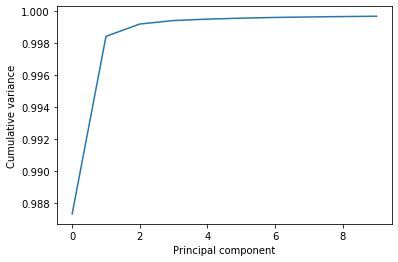

In [7]:
plt.plot(pc.cumulated_variance[:10])
plt.xlabel('Principal component')
plt.ylabel('Cumulative variance');

## Visualising projections into a reduced dimensional space

The `pc.transform()` method transforms a given atom group into weights $\mathbf{w}_i$ over each principal component $i$.

$$ \mathbf{w}_i(t) = (\mathbf{r}(t)-\mathbf{\overline{r}}) \cdot \mathbf{u}_i$$

$\mathbf{r}(t)$ are the atom group coordinates at time $t$, $\mathbf{\overline{r}}$ are the mean coordinates used in the PCA, and $\mathbf{u}_i$ is the $i$th principal component eigenvector $\mathbf{u}$.

While the given atom group must have the same number of atoms that the principal components were calculated over, it does not have to be the same group.

Again, passing `n_components=None` will tranform your atom group over every component. Below, we limit the output to projections over 5 principal components only.

In [8]:
transformed = pc.transform(backbone, n_components=5)
transformed.shape

(98, 5)

The output has the shape (n_frames, n_components). For easier analysis and plotting we can turn the array into a DataFrame.

In [9]:
df = pd.DataFrame(transformed, 
                  columns=['PC{}'.format(i+1) for i in range(5)])
df['Time (ps)'] = df.index * u.trajectory.dt
df.head()

,PC1,PC2,PC3,PC4,PC5,Time (ps)
0,467.196619,-105.669628,-29.537019,15.330358,8.465860,0.0
1,468.395260,-103.081148,-27.197712,14.298920,6.729752,1.0
2,471.020048,-101.270240,-25.534047,12.428769,4.228560,2.0
3,472.270077,-99.293884,-24.800279,10.936442,3.766506,3.0
4,473.376589,-96.758178,-23.927651,11.201408,2.219911,4.0


There are several ways we can visualise the data. Using the Seaborn's `PairGrid` tool is the quickest and easiest way, if you have seaborn already installed.

<div class="alert alert-info">
    
**Note**

You will need to install the data visualisation library [Seaborn](https://seaborn.pydata.org/installing.html) for this function.

</div>

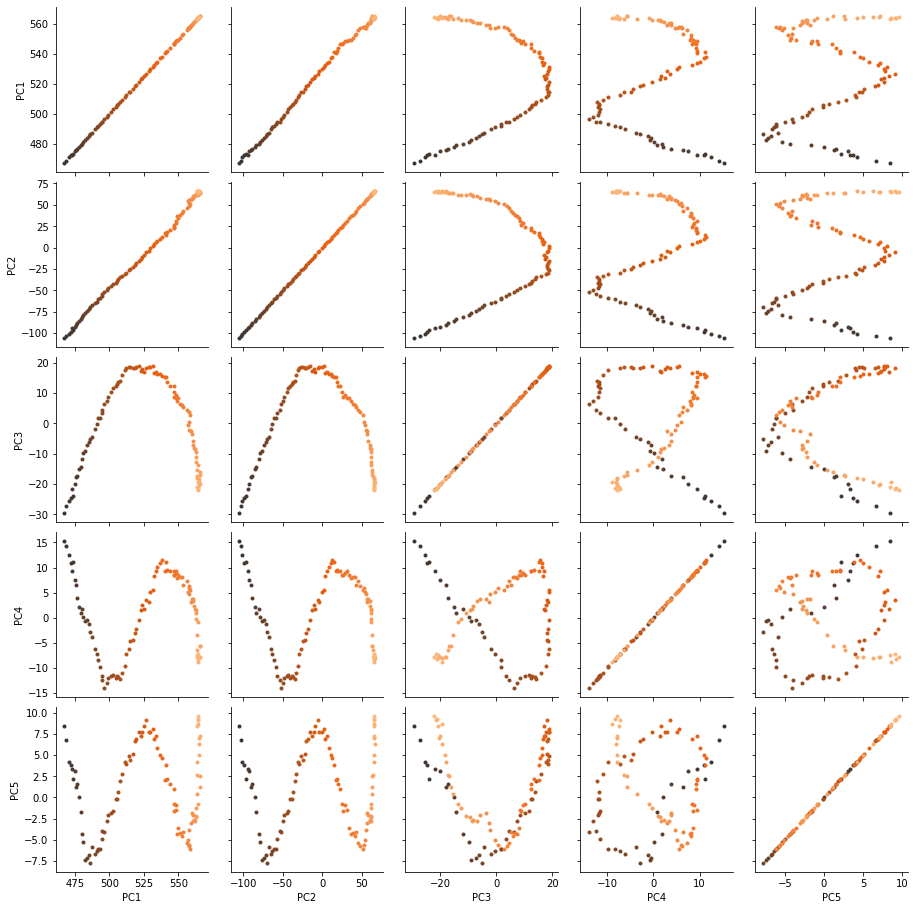

In [10]:
import seaborn as sns

g = sns.PairGrid(df, hue='Time (ps)', 
                 palette=sns.color_palette('Oranges_d',
                                           n_colors=len(df)))
g.map(plt.scatter, marker='.')

Another way to investigate the essential motions of the trajectory is to project the original trajectory onto each of the principal components, to visualise the motion of the principal component. The product of the weights $\mathbf{w}_i(t)$ for principal component $i$ with the eigenvector $\mathbf{u}_i$ describes fluctuations around the mean on that axis, so the projected trajectory $\mathbf{r}_i(t)$ is simply the fluctuations added onto the mean positions $\mathbf{\overline{r}}$.

$$ \mathbf{r}_i(t) = \mathbf{w}_i(t) \times \mathbf{u}_i + \mathbf{\overline{r}}$$

Below, we generate the projected coordinates of the first principal component.

In [145]:
pc1 = pc.p_components[:, 0]
trans1 = transformed[:, 0]
projected = np.outer(trans1, pc1)
coordinates = projected.reshape(len(trans1), -1, 3)

We can create a new universe from this to visualise the movement over the first principal component.

In [141]:
proj1 = mda.Merge(backbone)
proj1.load_new(coordinates)

<Universe with 855 atoms>

If you have `nglview` installed, you can view the trajectory in the notebook. Otherwise, you can write the trajectory out to a file and use another program such as VMD. Below, we create a movie of the component.

In [148]:
import nglview as nv
import warnings
# suppress some MDAnalysis warnings about writing PDB files
warnings.filterwarnings('ignore')
view = nv.show_mdanalysis(proj1.atoms)
view

In [147]:
from nglview.contrib.movie import MovieMaker
movie = MovieMaker(view, output='pc1.gif', in_memory=True)
movie.make()

IntProgress(value=0, description='Rendering ...', max=97)

![pc1 gif](pc1.gif)